# Linear Regression

## Dataset: [Seoul Bike Sharing Demand](https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand)
folder: seoul+bike+sharing+demand

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
from sklearn.linear_model import LinearRegression
import tensorflow as tf

# Data PreProssing

In [2]:
df = pd.read_csv("seoul+bike+sharing+demand/SeoulBikeData.csv").drop(["Date", "Holiday", "Seasons", "Hour"], axis=1) # not important columns

In [3]:
df

,Rented Bike Count,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Functioning Day
0,254,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Yes
1,204,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Yes
2,173,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Yes
3,107,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Yes
4,78,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Yes
...,...,...,...,...,...,...,...,...,...,...
8755,1003,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Yes
8756,764,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Yes
8757,694,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Yes
8758,712,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Yes


In [4]:
dataset_cols = ["bike_count", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]

In [5]:
df.columns = dataset_cols

In [6]:
df.dtypes

bike_count       int64
temp           float64
humidity         int64
wind           float64
visibility       int64
dew_pt_temp    float64
radiation      float64
rain           float64
snow           float64
functional      object
dtype: object

In [7]:
df["functional"] = (df["functional"] == "Yes").astype(int)   # yes or no to 0 or 1

In [8]:
df

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
0,254,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,1
1,204,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,1
2,173,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,1
3,107,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,1
4,78,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
8755,1003,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,1
8756,764,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,1
8757,694,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,1
8758,712,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,1


## EDA

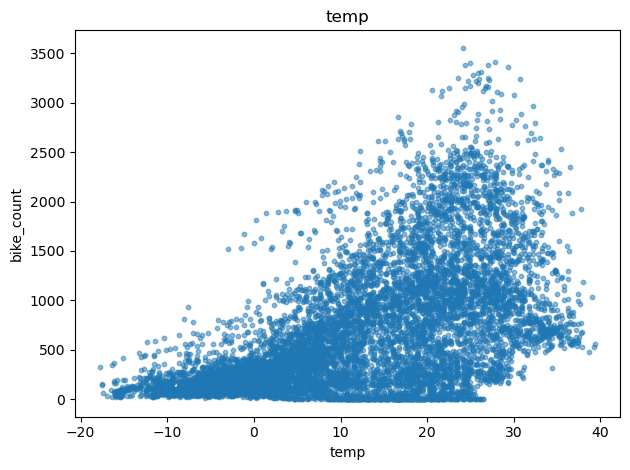

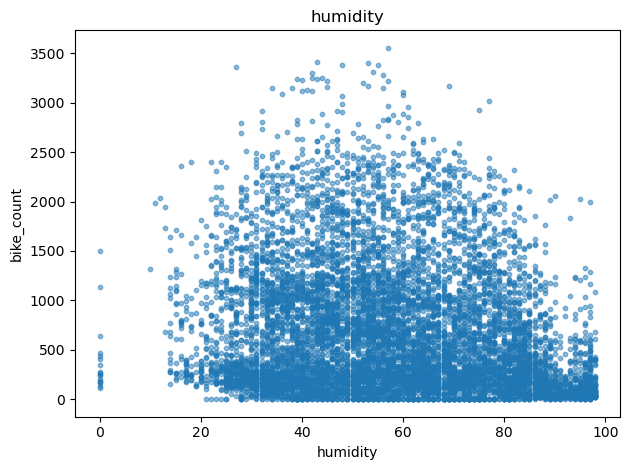

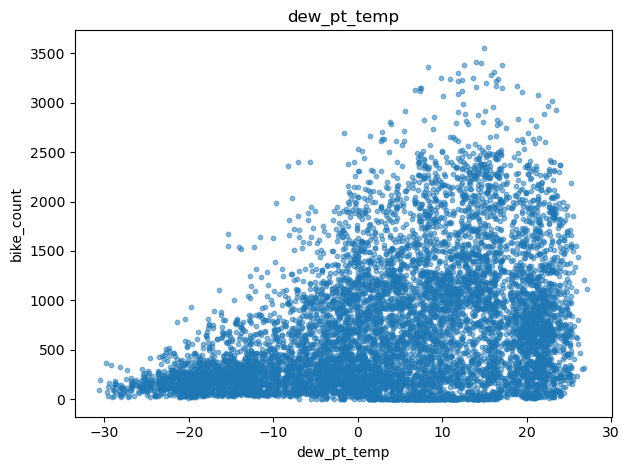

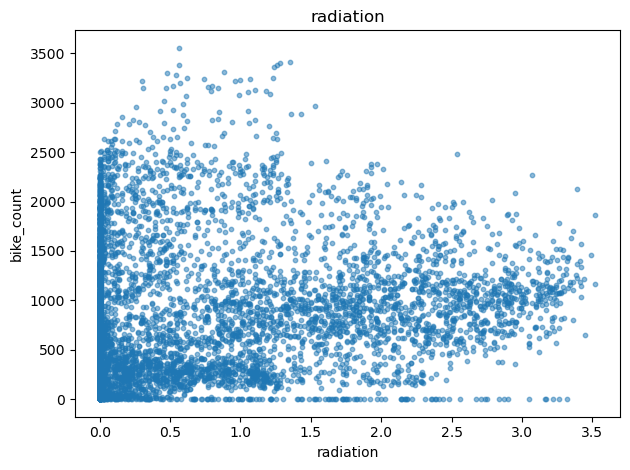

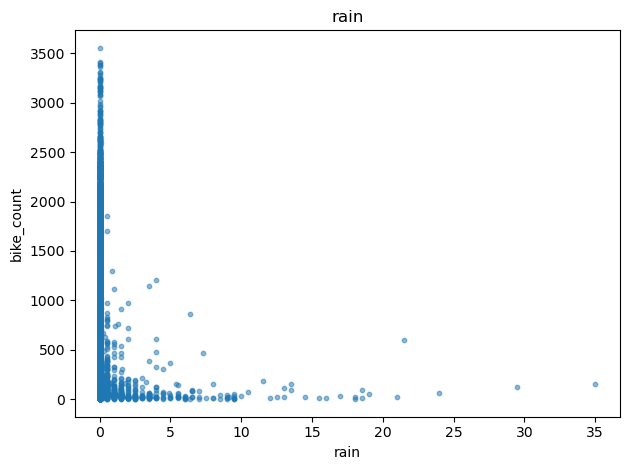

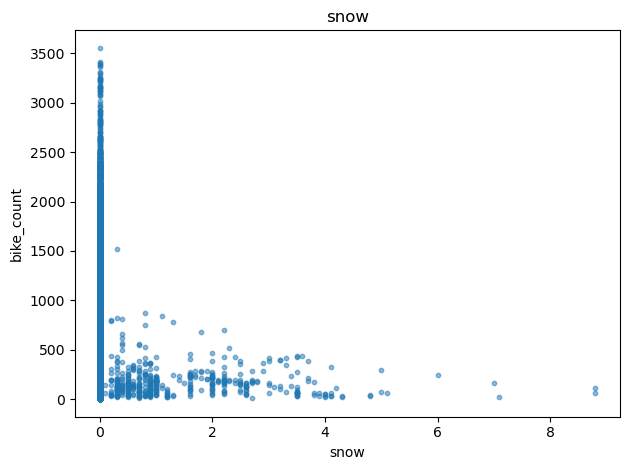

In [92]:
for label in df.columns[1:]:                   # all rows after 2nd rows
    plt.scatter(df[label], df["bike_count"], alpha=0.5, s=10)
    plt.title(label)
    plt.xlabel(label) 
    plt.ylabel("bike_count")
    plt.tight_layout()
    plt.show()

Functional column is useless

In [10]:
df = df.drop(["wind", "visibility", "functional"], axis=1)  #not very usefull coll

In [11]:
df.head(3)

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
0,254,-5.2,37,-17.6,0.0,0.0,0.0
1,204,-5.5,38,-17.6,0.0,0.0,0.0
2,173,-6.0,39,-17.7,0.0,0.0,0.0


### Train / Validation / Test 

In [24]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

or we could use `sklearn.model_selection.train_test_split` or `sklearn.model_selection.StratifiedShuffleSplit`

In [25]:
def get_xy(dataframe, y_label, x_labels=None):
    # deep copy dataframe to avoid modification in original dataframe
    dataframe = copy.deepcopy(dataframe)
    
    # If x_labels are not provided, use all columns except y_label as features (X)
    if x_labels is None:
        X = dataframe[[c for c in dataframe.columns if c!=y_label]].values
    else:
        # If only one x_label is provided, reshape it to be a 2D array
        if len(x_labels) == 1:
            X = dataframe[x_labels[0]].values.reshape(-1, 1)
        else:
            # Use the specified x_labels as features (X)
            X = dataframe[x_labels].values

    # Extract the y_label as the target variable (y)
    y = dataframe[y_label].values.reshape(-1, 1)
    
    # Combine features (X) and target variable (y) into a single array (data)
    data = np.hstack((X, y))

    return data, X, y

In [26]:
# Extracting features and target variable for the training set
# Using only the "temp" column as the feature

_, X_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels=["temp"])
_, X_val_temp, y_val_temp = get_xy(val, "bike_count", x_labels=["temp"])      # for validation
_, X_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels=["temp"])   # for test

In [27]:
# Displaying the lengths
print(f"length train, val, test: {len(X_train_temp)}, {len(X_val_temp)}, {len(X_test_temp)}")

length train, val, test: 5256, 1752, 1752


In [28]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [29]:
temp_reg.score(X_test_temp, y_test_temp) #R-squared

0.29770940017422964

29% (👎)

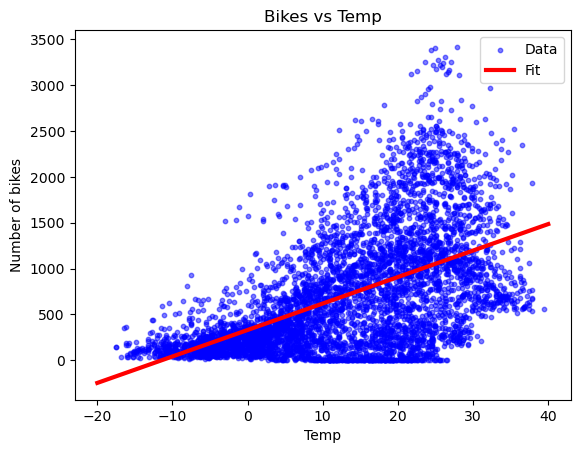

In [91]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue", alpha=0.5, s=10)
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

## Multiple Linear Regression

In [39]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
_, X_train_all, y_train_all = get_xy(train, "bike_count", x_labels=df.columns[1:])
_, X_val_all, y_val_all = get_xy(val, "bike_count", x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, "bike_count", x_labels=df.columns[1:])

In [40]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [41]:
all_reg.score(X_test_all, y_test_all)

0.4114263371471052

41% (👎)

In [66]:
y_pred_lr = all_reg.predict(X_test_all) #

### Rsidual plot

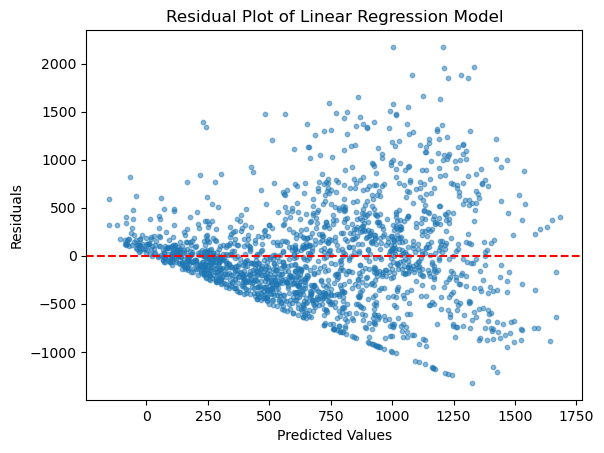

In [90]:
# Predictions on test
y_pred_all = all_reg.predict(X_test_all)

# Calculate residuals
residuals = y_test_all - y_pred_all

# residual plot
plt.scatter(y_pred_all, residuals, alpha=0.5, s=10)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot of Linear Regression Model')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

____

# with Neural Net / tensorflow

In [56]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1, 1))

In [57]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [58]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [59]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

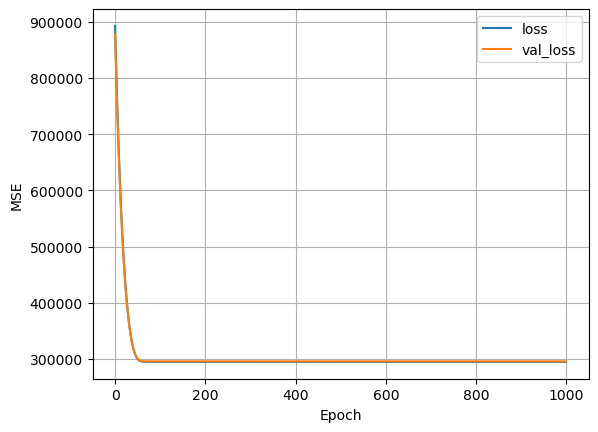

In [60]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(X_val_temp, y_val_temp)
)

plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


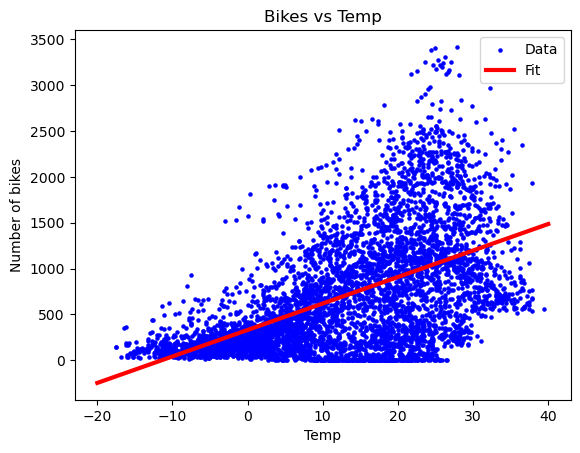

In [88]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue", s=5)
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

____

In [69]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(X_train_all)

In [70]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

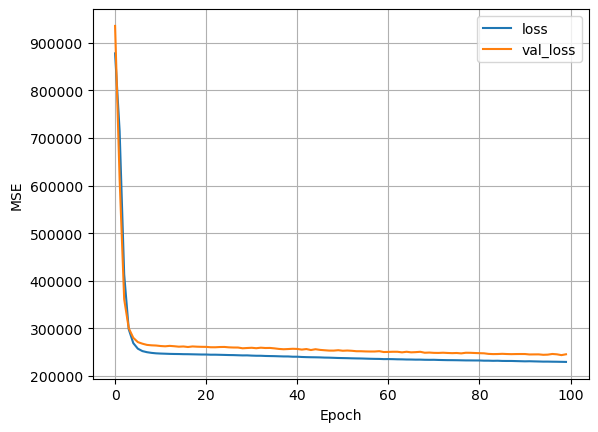

In [71]:
history = nn_model.fit(
    X_train_all, y_train_all,
    validation_data=(X_val_all, y_val_all),
    verbose=0, epochs=100
)

plot_loss(history)

In [72]:
# calculate the MSE for both linear reg and nn
y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn = nn_model.predict(X_test_all)

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [73]:
def MSE(y_pred, y_real):
  return (np.square(y_pred - y_real)).mean()

In [74]:
MSE(y_pred_lr, y_test_all)

241064.64887518657

In [75]:
MSE(y_pred_nn, y_test_all)

218217.24813370366

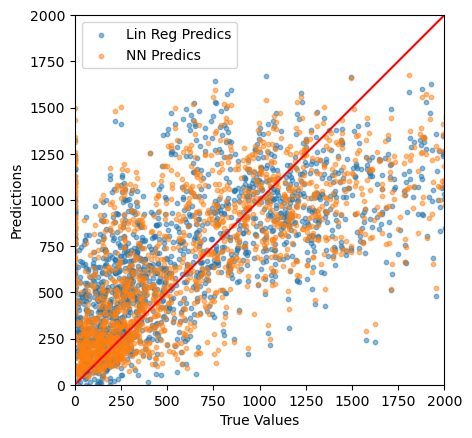

In [93]:
ax = plt.axes(aspect="equal")
plt.scatter(y_test_all, y_pred_lr, label="Lin Reg Predics", alpha=0.5, s=10)
plt.scatter(y_test_all, y_pred_nn, label="NN Predics", alpha=0.5, s=10)
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims = [0, 2000]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c="red")

____

🥲